In [3]:

!pip install transformers accelerate safetensors tqdm bitsandbytes matplotlib seaborn -q

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from scipy.stats import pearsonr
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
MODEL_NAME = "deepseek-ai/deepseek-coder-6.7b-base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

Device: cuda


In [6]:
DATASET_EXP3B_PATH = "/content/corpus.csv"
NUM_SAMPLES = 390
RANDOM_SEED = 42

In [7]:
PROMPT_TEMPLATES_EXP3B = {

    "MetaQuestionSimple": (
        "Which sentence is a better English sentence?\n"
        "1) {sent1}\n"
        "2) {sent2}\n"
    ),
    "MetaInstruct": (
        "You are a helpful writing assistant.\n"
        "Which sentence is a better English sentence?\n"
        "1) {sent1}\n"
        "2) {sent2}\n"
    ),
    "MetaQuestionComplex": (
        "Here are two English sentences:\n"
        "1) {sent1}\n"
        "2) {sent2}\n"
        "Which sentence is a better English sentence?\n"
    ),
}

In [8]:
from transformers import BitsAndBytesConfig

def load_model_and_tokenizer(model_name):
    """
    Loads the model and tokenizer from Hugging Face with 4-bit quantization
    to significantly reduce RAM usage.
    """
    print(f"Using device: {DEVICE}")
    print(f"Loading model: {model_name} with 4-bit quantization...")

    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
    )

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        quantization_config=quantization_config,
        device_map="auto" # GPU
    )

    model.eval()
    print("Model loaded successfully.")
    return model, tokenizer

In [9]:
def load_and_prepare_dataset_exp3b(filepath, num_samples, seed):

    print(f"Loading dataset for Experiment 3b from: {filepath}")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Dataset file not found at: {filepath}. Please update the DATASET_EXP3B_PATH variable.")

    df = pd.read_csv(filepath)


    required_columns = ['good_sentence', 'bad_sentence']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Dataset CSV must contain the columns: {required_columns}. Your file columns are: {df.columns.tolist()}")

    print(f"Loaded {len(df)} total sentence pairs. Required columns found.")

    if num_samples > len(df):
        print(f"Warning: Requested {num_samples} samples, but dataset only has {len(df)}. Using all items.")
        num_samples = len(df)

    print(f"Subsampling to {num_samples} items...")
    dataset_sample_df = df.sample(n=num_samples, random_state=seed)


    return dataset_sample_df.to_dict('records')

In [10]:
def get_full_sentence_log_prob(model, tokenizer, sentence):

    with torch.no_grad():

        if tokenizer.bos_token:
            sentence = tokenizer.bos_token + sentence

        inputs = tokenizer(sentence, return_tensors="pt").to(DEVICE)
        input_ids = inputs.input_ids

        outputs = model(**inputs)
        logits = outputs.logits

        # token position with the actual token that appeared at the next position.
        shifted_logits = logits[..., :-1, :].contiguous()
        labels = input_ids[..., 1:].contiguous()

        loss_fct = torch.nn.CrossEntropyLoss(reduction='sum')
        neg_log_prob = loss_fct(shifted_logits.view(-1, shifted_logits.size(-1)), labels.view(-1))

        return -neg_log_prob.item()

In [11]:
def get_next_word_log_probs(model, tokenizer, text_prompt, continuations):

    model.eval()
    with torch.inference_mode():

        prompt = text_prompt.rstrip() + "\n"

        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        inputs.pop("token_type_ids", None)
        logits_next = model(**inputs).logits[0, -1, :]
        log_probs = torch.nn.functional.log_softmax(logits_next, dim=-1)

        prompt_ids = tokenizer(prompt, add_special_tokens=False).input_ids
        scores = []
        for c in continuations:
            c_clean = c.strip()
            concat_ids = tokenizer(prompt + c_clean, add_special_tokens=False).input_ids
            if len(concat_ids) <= len(prompt_ids):
                concat_ids = tokenizer(prompt + " " + c_clean, add_special_tokens=False).input_ids
            if len(concat_ids) <= len(prompt_ids):
                raise ValueError(f"Could not identify answer boundary for option: {c_clean}")
            first_token_id = concat_ids[len(prompt_ids)]
            scores.append(log_probs[first_token_id].item())

        return scores

In [12]:
def run_experiment_3b(model, tokenizer, dataset):

    results = []
    print(f"\nRunning Experiment 3b on {len(dataset)} sentence pairs...")

    for item in tqdm(dataset):
        good_sent = item["good_sentence"]
        bad_sent = item["bad_sentence"]
        item_results = {"good_sentence": good_sent, "bad_sentence": bad_sent}

        # Direct
        direct_log_prob_good = get_full_sentence_log_prob(model, tokenizer, good_sent)
        direct_log_prob_bad = get_full_sentence_log_prob(model, tokenizer, bad_sent)
        item_results['direct_log_prob_good'] = direct_log_prob_good
        item_results['direct_log_prob_bad'] = direct_log_prob_bad

        # sents = [(good_sent, "1"), (bad_sent, "2")]
        # random.shuffle(sents)
        # sent1, label1 = sents[0]
        # sent2, label2 = sents[1]

        # correct_label = "1" if sent1 == good_sent else "2"

        # for method_name, template in PROMPT_TEMPLATES_EXP3B.items():
        #     prompt = template.format(sent1=sent1, sent2=sent2)
        #     # Get probabilities for the answer choices "1" and "2"
        #     meta_log_probs = get_next_word_log_probs(model, tokenizer, prompt, ["1", "2"])

        #     if correct_label == "1":
        #         item_results[f'{method_name}_log_prob_good'] = meta_log_probs[0] # Log prob of "1"
        #         item_results[f'{method_name}_log_prob_bad'] = meta_log_probs[1]  # Log prob of "2"
        #     else: # correct_label == "2"
        #         item_results[f'{method_name}_log_prob_good'] = meta_log_probs[1] # Log prob of "2"
        #         item_results[f'{method_name}_log_prob_bad'] = meta_log_probs[0]  # Log prob of "1"

        # Metalinguistic Prompting
        for method_name, template in PROMPT_TEMPLATES_EXP3B.items():

            prompt_a = template.format(sent1=good_sent, sent2=bad_sent)
            lp1_a, lp2_a = get_next_word_log_probs(model, tokenizer, prompt_a, ["1", "2"])
            good_a = lp1_a  # "1" good
            bad_a  = lp2_a  # "2" bad

            prompt_b = template.format(sent1=bad_sent, sent2=good_sent)
            lp1_b, lp2_b = get_next_word_log_probs(model, tokenizer, prompt_b, ["1", "2"])
            good_b = lp2_b  # "2" good
            bad_b  = lp1_b  # "1" bad

            item_results[f'{method_name}_log_prob_good'] = 0.5 * (good_a + good_b)
            item_results[f'{method_name}_log_prob_bad']  = 0.5 * (bad_a  + bad_b)

        results.append(item_results)

    return pd.DataFrame(results)

##        ANALYSIS & PLOTTING  

In [13]:
def analyze_results_exp3b(df):
    """
    Analyzes the results for Experiment 3b, calculating accuracy and Pearson correlations.
    """
    print("\n" + "="*20 + " Experiment 3b: Full Reproduction Results " + "="*20)
    print(f"Model: {MODEL_NAME}, Dataset: BLiMP ({len(df)} items)")

    methods = ["direct"] + list(PROMPT_TEMPLATES_EXP3B.keys())

    print("\n--- Task Performance (Accuracy) ---")
    print("This measures the proportion of pairs where the model correctly assigns a higher probability to the grammatical sentence.\n")

    for method in methods:
        correct_predictions = (df[f'{method}_log_prob_good'] > df[f'{method}_log_prob_bad']).sum()
        accuracy = correct_predictions / len(df)
        print(f"{method:<22}: {accuracy:.2%}")

    print("\n--- Internal Consistency (Pearson Correlation) ---")
    print("This measures how well the metalinguistic judgments align with the direct probability differences.\n")

    df['direct_diff'] = df['direct_log_prob_good'] - df['direct_log_prob_bad']
    for method_name in PROMPT_TEMPLATES_EXP3B.keys():
        df[f'{method_name}_diff'] = df[f'{method_name}_log_prob_good'] - df[f'{method_name}_log_prob_bad']
        corr, p_value = pearsonr(df['direct_diff'], df[f'{method_name}_diff'])
        print(f"Direct vs. {method_name:<20}: r = {corr:.3f} (p = {p_value:.3e})")

In [14]:
def generate_results_plot_exp3b(results_df):

    print("\nGenerating results plot for Experiment 3b...")

    methods = ["direct"] + list(PROMPT_TEMPLATES_EXP3B.keys())
    accuracies = [(results_df[f'{m}_log_prob_good'] > results_df[f'{m}_log_prob_bad']).mean() for m in methods]

    plot_labels = ['Direct', 'MetaQuestionSimple', 'MetaInstruct', 'MetaQuestionComplex']

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))

    colors = ['#2f2f2f', '#8f6A7B', '#c49a9a', '#f3e1d3']
    bars = ax.bar(plot_labels, accuracies, color=colors, edgecolor='black')

    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, label='Random Baseline (50%)')

    ax.set_ylabel('Accuracy', fontsize=12, labelpad=10)
    ax.set_title('Experiment 3b: Sentence Comparison (Syntax)', fontsize=15, pad=20)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', rotation=15, labelsize=11)
    ax.legend(loc='lower right')

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.015, f'{yval:.2%}', ha='center', va='bottom')

    output_filename = 'experiment_3b_results.pdf'
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"Plot saved to '{output_filename}'")

    plt.show()

In [15]:
def save_detailed_results_exp3b(results_df, filename="detailed_experiment_3b_output.csv"):

    results_df.to_csv(filename, index=False)
    print(f"\nDetailed results for Exp3b saved to '{filename}'")

##           MAIN EXECUTION

Using device: cuda
Loading model: deepseek-ai/deepseek-coder-6.7b-base with 4-bit quantization...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Model loaded successfully.
Loading dataset for Experiment 3b from: /content/corpus.csv
Loaded 390 total sentence pairs. Required columns found.
Subsampling to 390 items...

Running Experiment 3b on 390 sentence pairs...


100%|██████████| 390/390 [36:54<00:00,  5.68s/it]



Detailed results for Exp3b saved to 'detailed_experiment_3b_output.csv'

==================== Experiment 3b: Full Reproduction Results ====================
Model: deepseek-ai/deepseek-coder-6.7b-base, Dataset: BLiMP (390 items)

--- Task Performance (Accuracy) ---
This measures the proportion of pairs where the model correctly assigns a higher probability to the grammatical sentence.

direct                : 74.10%
MetaQuestionSimple    : 36.41%
MetaInstruct          : 41.79%
MetaQuestionComplex   : 47.95%

--- Internal Consistency (Pearson Correlation) ---
This measures how well the metalinguistic judgments align with the direct probability differences.

Direct vs. MetaQuestionSimple  : r = 0.018 (p = 7.261e-01)
Direct vs. MetaInstruct        : r = -0.086 (p = 9.104e-02)
Direct vs. MetaQuestionComplex : r = -0.006 (p = 9.002e-01)

Generating results plot for Experiment 3b...
Plot saved to 'experiment_3b_results.pdf'


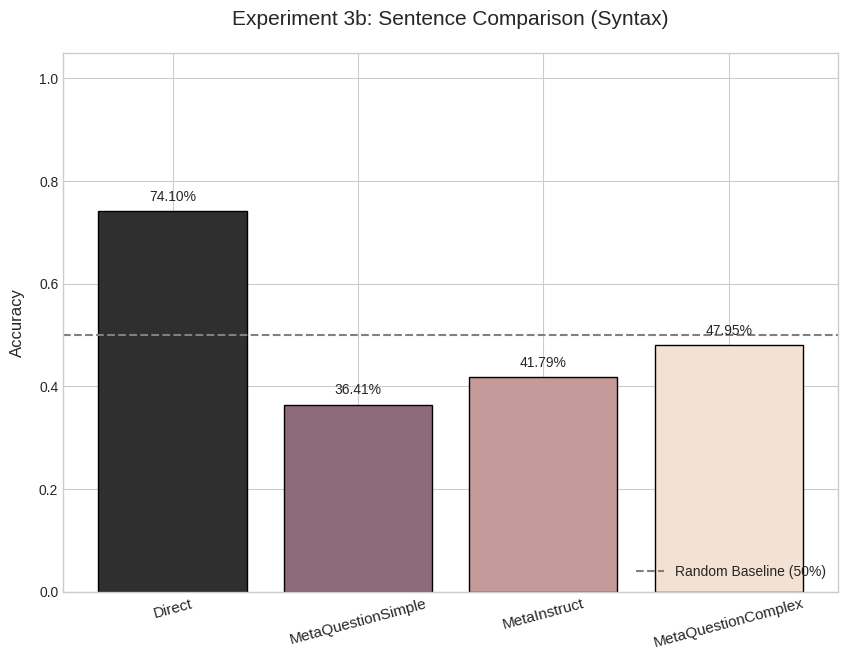

In [16]:
if __name__ == "__main__":
    try:
        model, tokenizer = load_model_and_tokenizer(MODEL_NAME)
        dataset_exp3b = load_and_prepare_dataset_exp3b(DATASET_EXP3B_PATH, NUM_SAMPLES, RANDOM_SEED)

        results_df_exp3b = run_experiment_3b(model, tokenizer, dataset_exp3b)

        save_detailed_results_exp3b(results_df_exp3b)
        analyze_results_exp3b(results_df_exp3b)
        generate_results_plot_exp3b(results_df_exp3b)

    except Exception as e:
        print(f"\n\n*** AN ERROR OCCURRED ***\n")
        import traceback
        traceback.print_exc()
        print("\n--- Checking code one more time ---")

In [17]:
def test_single_pair_exp3b(model, tokenizer, good_sentence, bad_sentence):

    print("\n" + "="*20 + " Experiment 3b — Single Pair " + "="*20)
    print(f"Good sentence       : {good_sentence}")
    print(f"Ungrammatical sentence: {bad_sentence}")
    print("-" * 62)

    results = []

    # --- Direct method ---
    lp_good = get_full_sentence_log_prob(model, tokenizer, good_sentence)
    lp_bad  = get_full_sentence_log_prob(model, tokenizer, bad_sentence)
    direct_diff = lp_good - lp_bad
    direct_acc = 1.0 if direct_diff > 0 else 0.0
    print(f"{'Direct:':<18} {'✅' if direct_acc == 1.0 else '❌'}  "
          f"acc={direct_acc:.2f}  Δ(logP_good - logP_bad)={direct_diff:.2f}")
    results.append(("Direct", direct_acc, abs(direct_diff)))

    #  Metalinguistic prompts
    for method_name, template in PROMPT_TEMPLATES_EXP3B.items():
        # Order A: 1)=good, 2)=bad  → correct if model outputs '1'
        prompt_a = template.format(sent1=good_sentence, sent2=bad_sentence)
        lp1_a, lp2_a = get_next_word_log_probs(model, tokenizer, prompt_a, ["1", "2"])
        acc_a = float(lp1_a > lp2_a)
        marg_a = (lp1_a - lp2_a)  # positive favors '1' (good)

        # Order B: 1)=bad, 2)=good  → correct if model outputs '2'
        prompt_b = template.format(sent1=bad_sentence, sent2=good_sentence)
        lp1_b, lp2_b = get_next_word_log_probs(model, tokenizer, prompt_b, ["1", "2"])
        acc_b = float(lp2_b > lp1_b)
        marg_b = (lp2_b - lp1_b)

        acc_avg = 0.5 * (acc_a + acc_b)
        marg_avg = 0.5 * (marg_a + marg_b)

        print(f"{method_name+':':<18} "
              f"{'✅' if acc_avg == 1.0 else ('➖' if acc_avg == 0.5 else '❌')}  "
              f"acc={acc_avg:.2f}  marg={marg_avg:.2f}  "
              f"[A: 1–2={marg_a:.2f} | B: 2–1={marg_b:.2f}]")

        results.append((method_name, acc_avg, marg_avg))

    best_name, best_score, best_tie = max(results, key=lambda t: (t[1], t[2]))
    print("-" * 62)
    label = "Accuracy"
    print(f"Best method: {best_name}   ({label}={best_score:.2f}, tie-break margin={best_tie:.2f})")


new_pairs_exp3b = [
    {
        "good": "The keys to the cabinet are on the table.",
        "bad":  "The keys to the cabinet is on the table."
    },
    {
        "good": "There seem to be many solutions.",
        "bad":  "There seems to be many solutions."
    },
    {
        "good": "Who did Mary say that John met yesterday?",
        "bad":  "Who did Mary say that John met him yesterday?"
    },
]

print("\n" + "="*25 + " Experiment 3b — Novel Pair Tests " + "="*25)
if 'model' in locals() and 'tokenizer' in locals():
    for pair in new_pairs_exp3b:
        test_single_pair_exp3b(
            model,
            tokenizer,
            good_sentence=pair["good"],
            bad_sentence=pair["bad"]
        )
else:
    print("Model and tokenizer not found")



========================= Experiment 3b — Novel Pair Tests =========================

==================== Experiment 3b — Single Pair ====================
Good sentence       : The keys to the cabinet are on the table.
Ungrammatical sentence: The keys to the cabinet is on the table.
--------------------------------------------------------------
Direct:            ✅  acc=1.00  Δ(logP_good - logP_bad)=2.50
MetaQuestionSimple: ➖  acc=0.50  marg=-0.05  [A: 1–2=0.02 | B: 2–1=-0.12]
MetaInstruct:      ❌  acc=0.00  marg=-0.04  [A: 1–2=-0.02 | B: 2–1=-0.06]
MetaQuestionComplex: ➖  acc=0.50  marg=-0.13  [A: 1–2=3.44 | B: 2–1=-3.70]
--------------------------------------------------------------
Best method: Direct   (Accuracy=1.00, tie-break margin=2.50)

==================== Experiment 3b — Single Pair ====================
Good sentence       : There seem to be many solutions.
Ungrammatical sentence: There seems to be many solutions.
-----------------------------------------------------------